In [442]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [443]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

## Image to Tensor Conversions

In [444]:
imsize = 512

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [523]:
set_folder = "Set10"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [524]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [447]:
device = torch.device("cuda")
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [448]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [449]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [450]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [451]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [452]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

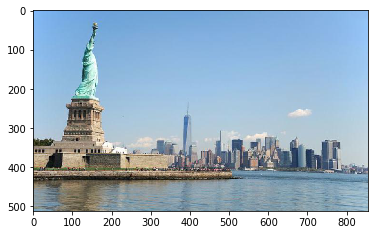

In [527]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [532]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.01)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000026  Content Loss = 0.000000 
Iteratio

Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000012 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000013 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000013 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000013 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000013 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000013 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000014 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000014 
Iteration 8:  Style Loss = 0.000026  Content Loss = 0.000014 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000014 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000014 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000015 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000015 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000015 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000015 
Iteration 9:  Style Loss = 0.000026  Content Loss = 0.000016 
Iteratio

Iteration 15:  Style Loss = 0.000006  Content Loss = 0.170185 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.172260 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.174295 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.176282 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.178235 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.180152 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.182036 
Iteration 15:  Style Loss = 0.000005  Content Loss = 0.183885 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.185699 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.187488 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.189248 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.190972 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.192676 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.194347 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.195995 
Iteration 15:  Style Loss = 0.000004  Content Loss = 0.

Iteration 21:  Style Loss = 0.000001  Content Loss = 0.288299 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.288644 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.288987 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.289326 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.289661 
Iteration 21:  Style Loss = 0.000001  Content Loss = 0.289993 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.290321 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.290648 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.290971 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.291289 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.291608 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.291921 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.292235 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.292544 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.292849 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.

Iteration 28:  Style Loss = 0.000000  Content Loss = 0.324608 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.324959 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.325311 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.325657 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.326002 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.326348 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.326696 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.327039 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.327387 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.327732 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.328070 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.328416 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.328755 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.329092 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.329429 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 34:  Style Loss = 0.000000  Content Loss = 0.354766 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.354923 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.355082 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.355241 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.355399 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.355558 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.355715 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.355872 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356028 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356184 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356348 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356506 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356664 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356825 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.356982 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.

Iteration 41:  Style Loss = 0.000000  Content Loss = 0.378531 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.378747 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.378959 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.379166 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.379382 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.379597 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.379809 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.380024 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.380242 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.380453 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.380663 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.380871 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.381081 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.381294 
Iteration 42:  Style Loss = 0.000000  Content Loss = 0.381506 
Iteration 42:  Style Loss = 0.000000  Content Loss = 0.

Iteration 47:  Style Loss = 0.000000  Content Loss = 0.401955 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.402083 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.402206 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.402330 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.402452 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.402576 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.402699 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.402819 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.402941 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.403063 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.403185 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.403306 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.403424 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.403545 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.403665 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.

Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413406 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413457 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413508 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413559 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413610 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413659 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413709 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413757 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413805 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413851 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413898 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.413945 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.413990 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.414035 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.414080 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.414497 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414455 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414414 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414371 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414327 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414283 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414238 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414192 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414146 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414100 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414051 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.414001 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.413952 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.413901 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.413851 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.

Iteration 67:  Style Loss = 0.000000  Content Loss = 0.403143 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.403018 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402896 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402771 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402646 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402516 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402387 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402261 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402133 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.402004 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.401876 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.401750 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.401622 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.401493 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.401360 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.

Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385875 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385747 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385630 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385505 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385379 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385259 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385137 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.385016 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384893 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384764 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384639 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384519 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384394 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384272 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.384151 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.

Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370732 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370623 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370513 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370399 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370287 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370179 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.370070 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.369962 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369854 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369745 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369639 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369530 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369426 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369322 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.369215 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.

Iteration 87:  Style Loss = 0.000000  Content Loss = 0.358192 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.358108 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.358028 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357948 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357863 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357783 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357705 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357625 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357540 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357462 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357381 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357300 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357220 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357138 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.357054 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 93:  Style Loss = 0.000000  Content Loss = 0.348251 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.348179 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.348109 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.348035 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.347964 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.347895 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347826 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347755 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347686 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347616 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347544 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347474 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347406 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347336 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.347267 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.

Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340461 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340411 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340362 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340313 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340263 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340216 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340168 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340122 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340072 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.340024 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.339979 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.339931 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.339885 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.339839 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.339791 
Iteration 100:  Style Loss = 0.000000  C

Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334857 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334816 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334774 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334733 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334694 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334655 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.334614 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334572 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334531 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334493 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334454 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334413 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334372 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334332 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.334292 
Iteration 107:  Style Loss = 0.000000  C

Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330348 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330318 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330289 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330260 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330230 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330201 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330173 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330144 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330114 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330085 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330056 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.330028 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.329998 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.329972 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.329941 
Iteration 113:  Style Loss = 0.000000  C

Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326639 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326609 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326582 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326554 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326526 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326497 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326468 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326441 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.326414 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.326385 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.326356 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.326327 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.326299 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.326272 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.326243 
Iteration 120:  Style Loss = 0.000000  C

Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323331 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323310 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323287 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323264 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323243 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323221 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323198 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323178 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323155 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323133 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323110 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323088 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323066 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323044 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.323024 
Iteration 126:  Style Loss = 0.000000  C

Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320731 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320712 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320694 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320678 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320658 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320639 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320622 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320604 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320587 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320569 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.320550 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.320533 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.320515 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.320498 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.320481 
Iteration 133:  Style Loss = 0.000000  C

Iteration 138:  Style Loss = 0.000000  Content Loss = 0.318716 
Iteration 138:  Style Loss = 0.000000  Content Loss = 0.318703 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318690 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318677 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318664 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318651 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318639 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318627 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318614 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318600 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318588 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318574 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318561 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318550 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.318536 
Iteration 139:  Style Loss = 0.000000  C

Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317178 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317167 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317155 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317144 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317132 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317121 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317110 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317099 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317087 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317076 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317064 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317054 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.317042 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.317031 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.317020 
Iteration 146:  Style Loss = 0.000000  C

Iteration 151:  Style Loss = 0.000000  Content Loss = 0.315789 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.315779 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.315768 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.315758 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315749 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315739 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315729 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315720 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315710 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315700 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315690 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315680 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315671 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315661 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.315652 
Iteration 152:  Style Loss = 0.000000  C

Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314569 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314560 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314551 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314542 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314533 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314524 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314514 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314505 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314495 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314486 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314477 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314468 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314459 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314450 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.314440 
Iteration 159:  Style Loss = 0.000000  C

Iteration 164:  Style Loss = 0.000000  Content Loss = 0.313510 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.313503 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.313496 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.313490 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.313483 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.313476 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313469 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313461 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313455 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313448 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313441 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313433 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313426 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313419 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.313412 
Iteration 165:  Style Loss = 0.000000  C

Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312699 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312693 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312688 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312682 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312676 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312670 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312665 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312659 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312653 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312648 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312643 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312637 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312632 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312626 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.312620 
Iteration 171:  Style Loss = 0.000000  C

Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312050 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312046 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312041 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312037 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312033 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312029 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312025 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.312021 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.312017 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.312013 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.312008 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.312004 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.312000 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.311996 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.311992 
Iteration 178:  Style Loss = 0.000000  C

Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311598 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311595 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311592 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311589 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311586 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311582 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311579 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311576 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311573 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311570 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311567 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311563 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311561 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311557 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.311554 
Iteration 184:  Style Loss = 0.000000  C

Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311206 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311203 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311200 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311197 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311194 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311192 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311189 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311186 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311183 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.311180 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.311178 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.311175 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.311172 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.311169 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.311166 
Iteration 191:  Style Loss = 0.000000  C

Iteration 196:  Style Loss = 0.000000  Content Loss = 0.310887 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310885 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310883 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310881 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310879 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310877 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310875 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310873 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310870 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310868 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310866 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310864 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310862 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310860 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.310858 
Iteration 197:  Style Loss = 0.000000  C

Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310618 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310616 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310614 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310612 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310610 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310607 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310605 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310603 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310601 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310599 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310597 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.310595 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.310593 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.310591 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.310589 
Iteration 204:  Style Loss = 0.000000  C

Iteration 209:  Style Loss = 0.000000  Content Loss = 0.310398 
Iteration 209:  Style Loss = 0.000000  Content Loss = 0.310397 
Iteration 209:  Style Loss = 0.000000  Content Loss = 0.310395 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310394 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310393 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310392 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310391 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310389 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310388 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310387 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310385 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310384 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310383 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310382 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.310381 
Iteration 210:  Style Loss = 0.000000  C

Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310256 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310255 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310254 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310253 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310252 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310251 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310250 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310249 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310248 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310247 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310246 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310245 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310244 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.310243 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.310242 
Iteration 217:  Style Loss = 0.000000  C

Iteration 222:  Style Loss = 0.000000  Content Loss = 0.310132 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.310132 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.310131 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.310130 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.310129 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310128 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310127 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310126 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310125 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310124 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310123 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310123 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310122 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310121 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.310120 
Iteration 223:  Style Loss = 0.000000  C

Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310027 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310026 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310025 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310024 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310023 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310023 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310022 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310021 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310020 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310019 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310018 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310018 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310017 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310016 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.310015 
Iteration 229:  Style Loss = 0.000000  C

Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309923 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309922 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309921 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309920 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309919 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309918 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.309918 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309917 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309916 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309915 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309914 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309913 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309912 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309912 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.309911 
Iteration 236:  Style Loss = 0.000000  C

Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309821 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309821 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309820 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309819 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309819 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309818 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309817 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309817 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309816 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309815 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309815 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309814 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309813 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309813 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.309812 
Iteration 242:  Style Loss = 0.000000  C

Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309743 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309743 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309742 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309742 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309741 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309741 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309740 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309740 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.309739 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.309739 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.309738 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.309738 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.309737 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.309737 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.309736 
Iteration 249:  Style Loss = 0.000000  C

Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309678 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309677 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309677 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309676 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309676 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309675 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309674 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309674 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309673 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309673 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309672 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309672 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309671 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309671 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.309670 
Iteration 255:  Style Loss = 0.000000  C

Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309601 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309600 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309600 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309599 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309598 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309598 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309597 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309596 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309596 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309595 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.309594 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.309594 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.309593 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.309592 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.309592 
Iteration 262:  Style Loss = 0.000000  C

Iteration 267:  Style Loss = 0.000000  Content Loss = 0.309514 
Iteration 267:  Style Loss = 0.000000  Content Loss = 0.309514 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309513 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309512 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309511 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309511 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309510 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309509 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309509 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309508 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309507 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309507 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309506 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309505 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.309504 
Iteration 268:  Style Loss = 0.000000  C

Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309415 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309414 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309413 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309412 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309411 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309411 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309410 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309409 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309408 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309407 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309406 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309405 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.309404 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.309404 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.309403 
Iteration 275:  Style Loss = 0.000000  C

Iteration 280:  Style Loss = 0.000000  Content Loss = 0.309295 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.309294 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.309293 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.309292 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309291 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309290 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309289 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309288 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309287 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309286 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309285 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309284 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309283 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309281 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.309280 
Iteration 281:  Style Loss = 0.000000  C

Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309077 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309074 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309071 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309068 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309066 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309063 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309060 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309057 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309055 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309052 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309049 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309046 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309043 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309039 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.309036 
Iteration 288:  Style Loss = 0.000000  C

Iteration 293:  Style Loss = 0.000000  Content Loss = 0.308309 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.308308 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.308306 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.308305 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.308304 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.308302 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308301 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308300 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308298 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308297 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308296 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308294 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308293 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308291 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.308290 
Iteration 294:  Style Loss = 0.000000  C

Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307644 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307631 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307621 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307611 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307589 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307578 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307561 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307548 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307534 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307520 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307511 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307308 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307305 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307302 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.307299 
Iteration 300:  Style Loss = 0.000000  C

Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306178 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306175 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306172 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306168 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306165 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306161 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306157 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.306153 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306148 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306143 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306138 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306131 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306124 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306115 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.306106 
Iteration 307:  Style Loss = 0.000000  C

Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305629 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305628 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305625 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305624 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305622 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305619 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305617 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305614 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305612 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305608 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305605 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305601 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305597 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305593 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.305587 
Iteration 313:  Style Loss = 0.000000  C

Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304871 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304871 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304871 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.304870 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.304869 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.304869 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.304869 
Iteration 320:  Style Loss = 0.000000  C

Iteration 325:  Style Loss = 0.000000  Content Loss = 0.304814 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304809 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304804 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304799 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304793 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304786 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304779 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304771 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304763 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304755 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304747 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304736 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304726 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304715 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.304703 
Iteration 326:  Style Loss = 0.000000  C

Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303507 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303501 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303493 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303486 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303479 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303472 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303466 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303458 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303451 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303445 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303438 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.303431 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.303425 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.303418 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.303411 
Iteration 333:  Style Loss = 0.000000  C

Iteration 338:  Style Loss = 0.000000  Content Loss = 0.302794 
Iteration 338:  Style Loss = 0.000000  Content Loss = 0.302790 
Iteration 338:  Style Loss = 0.000000  Content Loss = 0.302785 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302780 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302776 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302772 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302766 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302762 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302757 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302752 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302747 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302743 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302737 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302733 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.302728 
Iteration 339:  Style Loss = 0.000000  C

Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302255 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302252 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302247 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302242 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302239 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302235 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302232 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302228 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302224 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302220 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302217 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302213 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302209 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.302205 
Iteration 346:  Style Loss = 0.000000  Content Loss = 0.302202 
Iteration 346:  Style Loss = 0.000000  C

Iteration 351:  Style Loss = 0.000000  Content Loss = 0.301789 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.301785 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.301782 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.301778 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.301775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301771 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301768 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301764 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301760 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301757 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301754 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301750 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301747 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301744 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.301740 
Iteration 352:  Style Loss = 0.000000  C

Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301389 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301386 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301384 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301381 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301379 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301376 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301373 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301370 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301368 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301365 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301362 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301360 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301357 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301354 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.301352 
Iteration 358:  Style Loss = 0.000000  C

Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301079 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301077 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301075 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301073 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301070 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301068 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.301066 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301064 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301062 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301060 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301058 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301056 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301053 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301051 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.301049 
Iteration 365:  Style Loss = 0.000000  C

Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300790 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300788 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300786 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300783 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300781 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300779 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300777 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300774 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300772 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300770 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300767 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300765 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300763 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300760 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.300758 
Iteration 371:  Style Loss = 0.000000  C

Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300519 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300518 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300516 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300514 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300512 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300510 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300509 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300507 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.300505 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.300503 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.300501 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.300499 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.300498 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.300496 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.300494 
Iteration 378:  Style Loss = 0.000000  C

Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300315 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300314 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300313 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300312 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300311 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300310 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300308 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300307 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300306 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300305 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300304 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300303 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300301 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300300 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.300299 
Iteration 384:  Style Loss = 0.000000  C

Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300205 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300205 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300204 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300204 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300203 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300203 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300202 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300202 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300201 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300201 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.300200 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.300200 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.300199 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.300199 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.300198 
Iteration 391:  Style Loss = 0.000000  C

Iteration 396:  Style Loss = 0.000000  Content Loss = 0.300161 
Iteration 396:  Style Loss = 0.000000  Content Loss = 0.300161 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300160 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300160 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300160 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300160 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300159 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300159 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300159 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300159 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300158 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300158 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300158 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300158 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.300158 
Iteration 397:  Style Loss = 0.000000  C

Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300130 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300130 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300130 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300130 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300129 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300129 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300129 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300128 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300128 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300128 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300127 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300127 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.300127 
Iteration 404:  Style Loss = 0.000000  Content Loss = 0.300126 
Iteration 404:  Style Loss = 0.000000  Content Loss = 0.300126 
Iteration 404:  Style Loss = 0.000000  C

Iteration 409:  Style Loss = 0.000000  Content Loss = 0.300086 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.300085 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.300085 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.300084 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300084 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300084 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300083 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300083 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300083 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300082 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300082 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300082 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300081 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300081 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.300080 
Iteration 410:  Style Loss = 0.000000  C

Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300042 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300042 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300042 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300042 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300041 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300041 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300041 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300040 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300040 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300040 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300040 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300039 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300039 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300039 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.300039 
Iteration 417:  Style Loss = 0.000000  C

Iteration 422:  Style Loss = 0.000000  Content Loss = 0.300018 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.300018 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300017 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300016 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300016 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.300016 
Iteration 423:  Style Loss = 0.000000  C

Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.300008 
Iteration 429:  Style Loss = 0.000000  C

Iteration 435:  Style Loss = 0.000000  Content Loss = 0.300000 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.300000 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.300000 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.300000 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.300000 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.300000 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.299999 
Iteration 436:  Style Loss = 0.000000  C

Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299984 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299983 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299983 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299983 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299983 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299983 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299983 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299982 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299982 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299982 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299982 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299982 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299982 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299981 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.299981 
Iteration 442:  Style Loss = 0.000000  C

Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299961 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299961 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299961 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299961 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299960 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299960 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299960 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299960 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299960 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299960 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299959 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.299959 
Iteration 450:  Style Loss = 0.000000  Content Loss = 0.299959 
Iteration 450:  Style Loss = 0.000000  Content Loss = 0.299959 
Iteration 450:  Style Loss = 0.000000  Content Loss = 0.299959 
Iteration 450:  Style Loss = 0.000000  C

Iteration 455:  Style Loss = 0.000000  Content Loss = 0.299936 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.299936 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.299936 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299936 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299936 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299935 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299935 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299935 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299935 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299935 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299934 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299934 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299934 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299934 
Iteration 456:  Style Loss = 0.000000  Content Loss = 0.299934 
Iteration 456:  Style Loss = 0.000000  C

Iteration 462:  Style Loss = 0.000000  Content Loss = 0.299912 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299912 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299912 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299912 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299912 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299912 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299911 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299911 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299911 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299911 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299911 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299911 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299910 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299910 
Iteration 463:  Style Loss = 0.000000  Content Loss = 0.299910 
Iteration 463:  Style Loss = 0.000000  C

Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299889 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299889 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299889 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299888 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299888 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299888 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299888 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299888 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299887 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299887 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299887 
Iteration 469:  Style Loss = 0.000000  Content Loss = 0.299887 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.299886 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.299886 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.299886 
Iteration 470:  Style Loss = 0.000000  C

Iteration 475:  Style Loss = 0.000000  Content Loss = 0.299845 
Iteration 475:  Style Loss = 0.000000  Content Loss = 0.299844 
Iteration 475:  Style Loss = 0.000000  Content Loss = 0.299844 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299844 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299843 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299842 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299842 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299841 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299841 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299840 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299840 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299839 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299839 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299838 
Iteration 476:  Style Loss = 0.000000  Content Loss = 0.299838 
Iteration 476:  Style Loss = 0.000000  C

Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299728 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299727 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299725 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299723 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299722 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299720 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299718 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299716 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299715 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299713 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299711 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299709 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299707 
Iteration 482:  Style Loss = 0.000000  Content Loss = 0.299705 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.299703 
Iteration 483:  Style Loss = 0.000000  C

Iteration 488:  Style Loss = 0.000000  Content Loss = 0.299372 
Iteration 488:  Style Loss = 0.000000  Content Loss = 0.299370 
Iteration 488:  Style Loss = 0.000000  Content Loss = 0.299368 
Iteration 488:  Style Loss = 0.000000  Content Loss = 0.299365 
Iteration 488:  Style Loss = 0.000000  Content Loss = 0.299363 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299360 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299357 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299355 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299352 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299349 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299347 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299344 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299341 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299338 
Iteration 489:  Style Loss = 0.000000  Content Loss = 0.299336 
Iteration 489:  Style Loss = 0.000000  C

Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298789 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298788 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298788 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298787 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298787 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298786 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298785 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298785 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298784 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298783 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298782 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298782 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298781 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298779 
Iteration 495:  Style Loss = 0.000000  Content Loss = 0.298778 
Iteration 495:  Style Loss = 0.000000  C

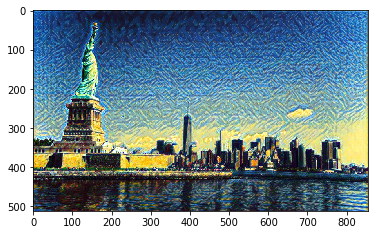

In [533]:
output = style_transfer(vgg, content, style, input_img, iters=500, style_w=50000000, content_w=1)
output.save("UpdatedSets/"+set_folder+"/output_large.png")